In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
from sklearn.metrics import make_scorer
import warnings
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
import pickle
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from category_encoders.target_encoder import TargetEncoder
warnings.filterwarnings('ignore')
import lightgbm as lgb
import pandas as pd 
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import os
from skopt.space import Real, Categorical, Integer
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import roc_auc_score        
        
import lightgbm as lgb
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from xgboost import XGBClassifier,XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
from itertools import combinations       
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/kaggle/input/emplyoee-fitness/sample submission.csv
/kaggle/input/emplyoee-fitness/Train.csv
/kaggle/input/emplyoee-fitness/Test.csv
/kaggle/input/pickle-1/cat_bias_m3
/kaggle/input/pickle-1/y_pred_final
/kaggle/input/pickle-1/cat_bias_m1
/kaggle/input/pickle-1/df
/kaggle/input/pickle-1/cat_bias_m2


In [2]:
# Pickle save/load

def pickle_save(filename,obj):
    outfile = open(filename,'wb')
    pickle.dump(obj,outfile)
    outfile.close()
    
def pickle_load(filename):
    infile = open(filename,'rb')
    obj = pickle.load(infile)
    infile.close()    
    return obj


In [3]:
# Below is the function for adding features based on the frequecy

def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])

In [4]:
# Below is the function for label encoding 

def lab_encoder(df,cat_cols):
    cat_cols=list(cat_cols)
    le = LabelEncoder()
    for col in cat_cols:
        df[col]= le.fit_transform(df[col].astype('str'))
    return df

In [5]:
# Loading train data
sample = pd.read_csv('/kaggle/input/emplyoee-fitness/sample submission.csv')
train = pd.read_csv('/kaggle/input/emplyoee-fitness/Train.csv')
print(train.shape)

train.head()

(13645, 22)


,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,11041,John,English,35,Male,JR85289,B.Tech,Electrical,Tier 1,7,12,2009,21,26,Married,5,SSE,Enterprise,Design,20,YearsOfExperince,95.40
1,15079,William,English,26,Male,JR87525,B.Tech,Artificial Intelligence,Tier 3,7,3,2018,15,19,Married,5,BA,MidSized,Engineering,6,NaN,67.09
2,18638,James,English,36,Female,JR87525,PhD,Computer Science,Tier 1,6,6,2015,15,24,Single,5,SDE,MidSized,Engineering,19,Gender,91.26
3,3941,Charles,English,29,Female,JR87525,BCA,Information Technology,Tier 2,5,6,2015,16,24,Married,5,SDE,Startup,Product,16,Gender,72.29
4,5936,George,English,25,Male,JR70175,Dual M.Tech,Computer Science,Tier 3,8,2,2019,24,32,Married,5,SDE,Enterprise,Engineering,10,DegreeBranch,86.34


In [6]:
# Loading test data

test = pd.read_csv('/kaggle/input/emplyoee-fitness/Test.csv')

EmpID = test['EmpID']

print(test.shape)

test.head()

(8745, 20)


,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
0,5664,Theo,Native,35,Male,JR85289,PhD,Information Technology,Tier 2,5,5,2016,27,34,Single,4,SDE,Enterprise,Finance,18
1,23568,Vernie,English,35,Male,JR85289,B.Tech,Information Technology,Tier 3,9,12,2009,29,33,Married,4,EM,Enterprise,Engineering,8
2,21490,Wendell,English,28,Male,JR87525,M.Tech,Artificial Intelligence,Tier 2,9,2,2019,18,25,Married,3,SDE,Startup,Engineering,18
3,8363,West,Hindi,37,Male,JR87525,MS,Computer Science,Tier 2,8,11,2010,7,12,Single,5,DS,Enterprise,Product,17
4,6165,Alford,Hindi,36,Female,JR85289,PhD,Artificial Intelligence,Tier 2,7,6,2015,22,32,Married,4,SDE,Startup,Engineering,9


In [7]:
# Percentage of missing values

train.isnull().sum()*100/train.shape[0]


EmpID                       0.000000
EmpName                     0.000000
LanguageOfCommunication     0.000000
Age                         0.000000
Gender                      0.000000
JobProfileIDApplyingFor     0.000000
HighestDegree               0.000000
DegreeBranch                0.000000
GraduatingInstitute         0.000000
LatestDegreeCGPA            0.000000
YearsOfExperince            0.000000
GraduationYear              0.000000
CurrentCTC                  0.000000
ExpectedCTC                 0.000000
MartialStatus               0.000000
EmpScore                    0.000000
CurrentDesignation          0.000000
CurrentCompanyType          0.000000
DepartmentInCompany         0.000000
TotalLeavesTaken            0.000000
BiasInfluentialFactor      24.448516
FitmentPercent              0.000000
dtype: float64

In [8]:
# Percentage of missing values

test.isnull().sum()*100/test.shape[0]


EmpID                      0.0
EmpName                    0.0
LanguageOfCommunication    0.0
Age                        0.0
Gender                     0.0
JobProfileIDApplyingFor    0.0
HighestDegree              0.0
DegreeBranch               0.0
GraduatingInstitute        0.0
LatestDegreeCGPA           0.0
YearsOfExperince           0.0
GraduationYear             0.0
CurrentCTC                 0.0
ExpectedCTC                0.0
MartialStatus              0.0
EmpScore                   0.0
CurrentDesignation         0.0
CurrentCompanyType         0.0
DepartmentInCompany        0.0
TotalLeavesTaken           0.0
dtype: float64

<AxesSubplot:xlabel='GraduationYear', ylabel='Density'>

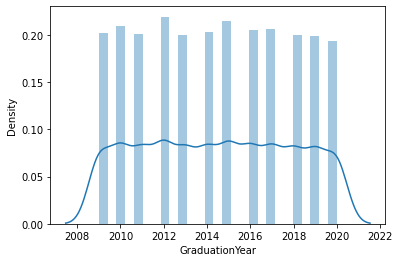

In [25]:
sns.distplot(train['GraduationYear'])

<AxesSubplot:xlabel='LatestDegreeCGPA', ylabel='Density'>

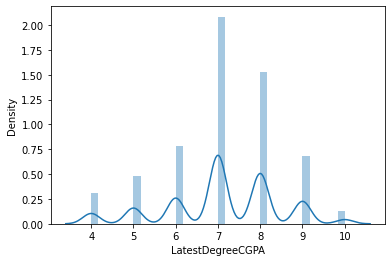

In [24]:
sns.distplot(train['LatestDegreeCGPA'])

<AxesSubplot:xlabel='TotalLeavesTaken', ylabel='Density'>

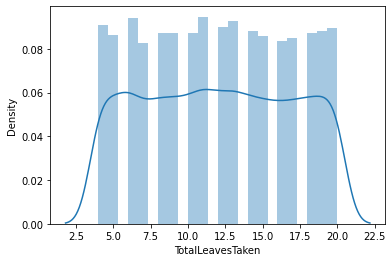

In [23]:
sns.distplot(train['TotalLeavesTaken'])

<AxesSubplot:xlabel='EmpScore', ylabel='Density'>

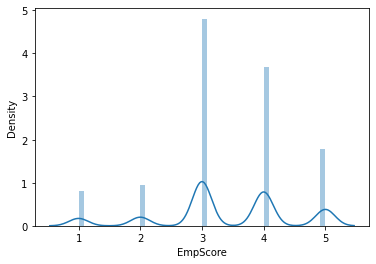

In [22]:
sns.distplot(train['EmpScore'])

<AxesSubplot:xlabel='ExpectedCTC', ylabel='Density'>

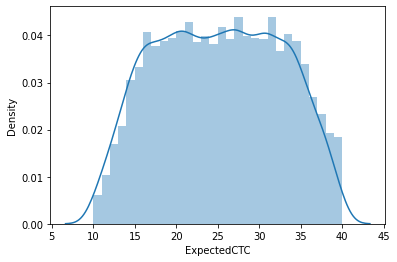

In [21]:
sns.distplot(train['ExpectedCTC'])

<AxesSubplot:xlabel='CurrentCTC', ylabel='Density'>

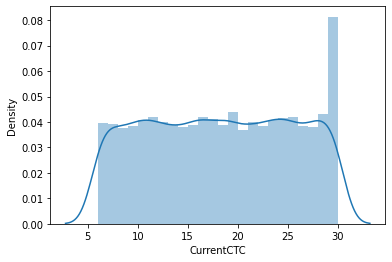

In [20]:
sns.distplot(train['CurrentCTC'])

<AxesSubplot:xlabel='YearsOfExperince', ylabel='Density'>

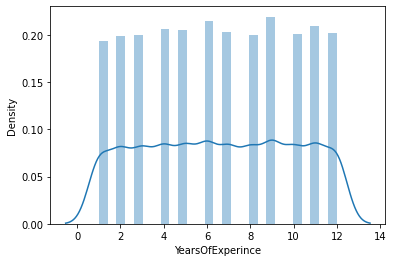

In [19]:
sns.distplot(train['YearsOfExperince'])

<AxesSubplot:xlabel='Age', ylabel='Density'>

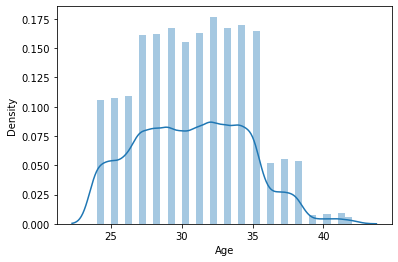

In [17]:
sns.distplot(train['Age'])

<AxesSubplot:xlabel='FitmentPercent', ylabel='Density'>

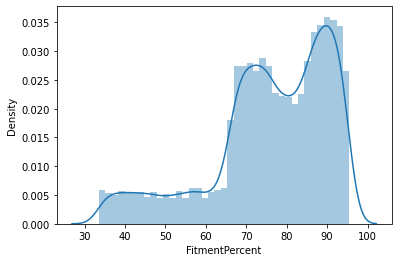

In [15]:
sns.distplot(train['FitmentPercent'])


[Text(0.5, 1.0, 'FitmentPercent when BiasInfluentialFactor is LatestDegreeCGPA')]

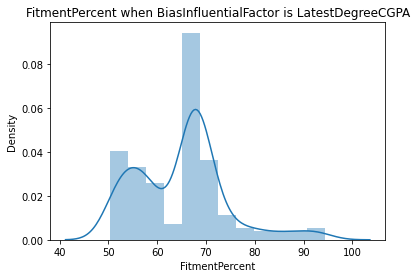

In [14]:
sns.distplot(train[train['BiasInfluentialFactor']=='LatestDegreeCGPA']['FitmentPercent']).set(title='FitmentPercent when BiasInfluentialFactor is LatestDegreeCGPA')

[Text(0.5, 1.0, 'FitmentPercent when BiasInfluentialFactor is YearsOfExperince')]

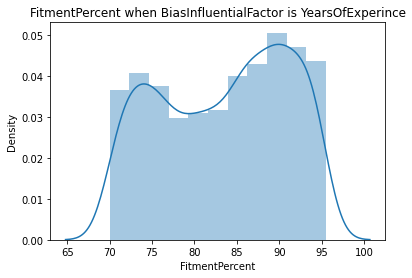

In [16]:
sns.distplot(train[train['BiasInfluentialFactor']=='YearsOfExperince']['FitmentPercent']).set(title='FitmentPercent when BiasInfluentialFactor is YearsOfExperince')


In [12]:
# Adding a test/train identifier 
train['train_or_test']='train'
test['train_or_test']='test'

# Combining dataset
df=pd.concat([train,test],axis=0)

In [ ]:
# Categorical and Numerical columns 
cat_cols = set(df.select_dtypes(include = 'object'))-set(['train_or_test','EmpID','EmpName'])
num_cols = set(df.select_dtypes(include=['int64','float64']))-set(['GraduationYear'])
cat_cols.add('GraduationYear')

### Handling missing values

In [ ]:
# Encoding features

cat_cols_miss = cat_cols-set(['BiasInfluentialFactor'])
df = lab_encoder(df,cat_cols_miss)

y_map = {'CurrentCompanyType':0, 'EmpScore':1, 'MartialStatus':2, 'Ethinicity':3,
       'DegreeBranch':4, 'HighestDegree':5, 'Gender':6, 'LatestDegreeCGPA':7,
       'YearsOfExperince':8}

y_map_inv = {0:'CurrentCompanyType', 1:'EmpScore', 2:'MartialStatus', 3:'Ethinicity',
       4:'DegreeBranch', 5:'HighestDegree', 6:'Gender', 7:'LatestDegreeCGPA',
       8:'YearsOfExperince'}

y_map_inv_temp = {0:'CurrentCompanyType', 1:'EmpScore', 2:'MartialStatus', 3:'LanguageOfCommunication',
       4:'DegreeBranch', 5:'HighestDegree', 6:'Gender', 7:'LatestDegreeCGPA',
       8:'YearsOfExperince'}

df['BiasInfluentialFactor'] = df['BiasInfluentialFactor'].map(y_map)

In [ ]:
# Get index of missing value dataframe

miss_idx= np.where(df['BiasInfluentialFactor'].isnull())[0]

#Divide test & train 

df_miss_test = df.iloc[miss_idx]
df_miss_test = df_miss_test.drop(['BiasInfluentialFactor','EmpID','EmpName','train_or_test','FitmentPercent'],axis=1)
indexes_to_keep = set(range(df.shape[0])) - set(miss_idx)
df_miss_train = df.take(list(indexes_to_keep))
df_miss_train = df_miss_train.drop(['EmpID','EmpName','train_or_test','FitmentPercent'],axis=1)

In [ ]:
df_miss_train.head()

In [ ]:
Y=df_miss_train['BiasInfluentialFactor']
X=df_miss_train.drop(['BiasInfluentialFactor'],axis=1)

In [ ]:
oof_pred  = np.zeros((len(df_miss_train),9))
y_pred_final   = np.zeros((len(df_miss_test),9))
n_splits  = 5

cat_cols =cat_cols_miss

kf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=28052021)

for i,(train_idx,val_idx) in enumerate(kf.split(X,Y)):  

    wghts  = [0]*3
    test_roc_score   = []


    X_train, y_train = X.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], Y.iloc[val_idx]


    print('\nFold: {}\n'.format(i+1))

    model1 = CatBoostClassifier(loss_function='MultiClass',learning_rate = 0.03,random_state=41, custom_metric=['AUC'])
    model1.fit(X_train,y_train,cat_features=cat_cols,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    testpred1 = model1.predict_proba(X_val)
    test_roc_score.append(roc_auc_score(y_val, testpred1,multi_class='ovo'))
    print("Test ROC AUC for model 1: %.4f"%(roc_auc_score(y_val, testpred1,multi_class='ovo')))

    model2 = CatBoostClassifier(loss_function='MultiClass',learning_rate = 0.04,random_state=42, custom_metric=['AUC'])
    model2.fit(X_train,y_train,cat_features=cat_cols,eval_set=(X_val, y_val),early_stopping_rounds=40,verbose=100)
    testpred2 = model2.predict_proba(X_val)
    test_roc_score.append(roc_auc_score(y_val, testpred2,multi_class='ovo'))
    print("Test ROC AUC for model 2: %.4f"%(roc_auc_score(y_val, testpred2,multi_class='ovo')))

    model3 = CatBoostClassifier(loss_function='MultiClass',learning_rate = 0.05,random_state=43, custom_metric=['AUC'])
    model3.fit(X_train,y_train,cat_features=cat_cols,eval_set=(X_val, y_val),early_stopping_rounds=20,verbose=100)
    testpred3 = model3.predict_proba(X_val)
    test_roc_score.append(roc_auc_score(y_val, testpred3,multi_class='ovo'))
    print("Test ROC AUC for model 3: %.4f"%(roc_auc_score(y_val, testpred3,multi_class='ovo')))

    wghts = np.exp(-1000*np.array(test_roc_score/sum(test_roc_score)))
    wghts = wghts/sum(wghts)

    val_pred   = wghts[0]*testpred1+wghts[1]*testpred2 +wghts[2]*testpred3
    print('validation roc_auc_score fold-',i+1,': ',roc_auc_score(y_val, val_pred,multi_class='ovo'))

    oof_pred[val_idx] = val_pred
    y_pred_final += (wghts[0]*model1.predict_proba(df_miss_test)+wghts[1]*model2.predict_proba(df_miss_test)+wghts[2]*model3.predict_proba(df_miss_test))/(n_splits)

    print('\n')

print('OOF ROC_AUC_Score:- ',(roc_auc_score(Y,oof_pred,multi_class='ovo')))



In [ ]:
# # Saving the above model

# pickle_save('cat_bias_m1',model1)
# pickle_save('cat_bias_m2',model2)
# pickle_save('cat_bias_m3',model3)
# pickle_save('df',df)

In [ ]:
# Load model
model1 = pickle_load('/kaggle/input/pickle-1/cat_bias_m3')
model2 = pickle_load('/kaggle/input/pickle-1/cat_bias_m2')
model3 = pickle_load('/kaggle/input/pickle-1/cat_bias_m3')
y_pred_final = pickle_load('/kaggle/input/pickle-1/y_pred_final')

In [ ]:
# Preparing test and train

df_train = df[df['train_or_test']=='train'].drop(['EmpID','EmpName','train_or_test'],axis=1)
df_test = df[df['train_or_test']=='test'].drop(['EmpID','EmpName','train_or_test','FitmentPercent'],axis=1)

In [ ]:
# Predicting missing value of train

X_temp = df_train.drop(['FitmentPercent'],axis=1)
miss_x_temp = np.where(X_temp['BiasInfluentialFactor'].isnull())[0]
X_temp1 = X_temp.iloc[miss_x_temp].drop(['BiasInfluentialFactor'],axis=1)

y_temp_pred1 = model1.predict(X_temp1)
y_temp_pred2 = model2.predict(X_temp1)
y_temp_pred3 = model3.predict(X_temp1)


In [ ]:
# Classification based on votes for train

y_miss_val = [-1]*len(y_temp_pred3)
for i in range(len(y_temp_pred3)):
    if y_temp_pred1[i] == y_temp_pred2[i] == y_temp_pred3[i]:
        y_miss_val[i] = int(y_temp_pred1[i])
    elif y_temp_pred1[i] == y_temp_pred2[i]:
        y_miss_val[i] = int(y_temp_pred1[i])
    elif y_temp_pred2[i] == y_temp_pred3[i]:
        y_miss_val[i] = int(y_temp_pred2[i])
    elif y_temp_pred1[i] == y_temp_pred3[i]:
        y_miss_val[i] = int(y_temp_pred1[i])  
    else:
        y_miss_val[i] = int(y_temp_pred1[i]) 
        

In [ ]:
# Missing value imputation train

for i in range(len(y_miss_val)):
     X_temp.at[miss_x_temp[i],'BiasInfluentialFactor'] = y_miss_val[i]
        
df_train['BiasInfluentialFactor'] = X_temp['BiasInfluentialFactor']

In [ ]:
# Predicting missing value of test

y_temp_test_pred1 = model1.predict(df_test)
y_temp_test_pred2 = model2.predict(df_test)
y_temp_test_pred3 = model3.predict(df_test)


In [ ]:
# Missing value imputation for test 

y_miss_testval = [-1]*len(y_temp_test_pred1)
for i in range(len(y_temp_test_pred1)):
    if y_temp_test_pred1[i] == y_temp_test_pred2[i] == y_temp_test_pred3[i]:
        y_miss_testval[i] = int(y_temp_test_pred1[i])
        
    elif y_temp_test_pred1[i] == y_temp_test_pred2[i]:
        y_miss_testval[i] = int(y_temp_test_pred1[i])
        
    elif y_temp_test_pred2[i] == y_temp_test_pred3[i]:
        y_miss_testval[i] = int(y_temp_test_pred2[i])
        
    elif y_temp_test_pred1[i] == y_temp_test_pred3[i]:
        y_miss_testval[i] = int(y_temp_test_pred1[i])  
        
    else:
        y_miss_testval[i] = int(y_temp_test_pred1[i]) 
        

In [ ]:
# Missing value imputation test

for i in range(len(y_miss_testval)):
    df_test.at[i,'BiasInfluentialFactor'] = y_miss_testval[i]

In [ ]:
df_test.head()

In [ ]:
df_train.head()

In [ ]:
# Adding a test/train identifier 
df_train['train_or_test']='train'
df_test['train_or_test']='test'
df_test['FitmentPercent'] = np.nan

df_new= pd.concat([df_train,df_test])

In [ ]:
# Adding a new feature 

df_new['BiasInfluentialFactor_label'] = df_new['BiasInfluentialFactor'].map(y_map_inv_temp) 
df_new['BiasInfluentialFactor_value'] = -1


In [ ]:
# Computing BiasInfluentialFactor_value

for index, row in df_new.iterrows():
    bias = df_new.iloc[index]['BiasInfluentialFactor_label']
    df_new.at[index,'BiasInfluentialFactor_value'] = df_new.iloc[index][bias]

In [ ]:
# Spliting data

df_train = df_new[df_new['train_or_test']=='train'].drop(['train_or_test','BiasInfluentialFactor_label'],axis=1)
df_test = df_new[df_new['train_or_test']=='test'].drop(['train_or_test','FitmentPercent','BiasInfluentialFactor_label'],axis=1)

In [ ]:
# Final Model

Y = df_train['FitmentPercent']
X = df_train.drop(['FitmentPercent'],axis=1)

# Preparing for stacked classifier 

estimators = [
     ('xg', XGBRegressor(n_estimators=500,random_state=42)), 
     ('cb',CatBoostRegressor(random_state=42)), 
     ('lbg',lgb.LGBMRegressor(verbose=-1,verbose_eval=False))]
      
    
n_splits  = 5
test_rmse_score = []
test_r2_score = []

kf=KFold(n_splits=n_splits,shuffle=True,random_state=2062021)

for i,(train_idx,val_idx) in enumerate(kf.split(X,Y)):  

    
    X_train, y_train = X.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], Y.iloc[val_idx]


    print('\nFold: {}\n'.format(i+1))

    stk1=StackingRegressor(estimators=estimators, 
                            final_estimator=CatBoostRegressor(learning_rate = 0.03,random_state=42))

    stk1.fit(X_train,y_train)
    
    testpred1 = stk1.predict(X_val)
    
    test_r2_score.append(r2_score(y_val, testpred1))
    print("Test r2_score for model 1: %.4f"%(r2_score(y_val, testpred1)))
    
    test_rmse_score.append(mean_squared_error(y_val, testpred1,squared=False))
    print("Test mean_squared_error for model 1: %.4f"%(mean_squared_error(y_val, testpred1,squared=False)))
    
    val_pred   = testpred1
    
    print('\n')



In [ ]:
# Preparing submission

y_pred = stk1.predict(df_test)

sub = pd.DataFrame({'EmpID':EmpID,'BiasInfluentialFactor':df_test['BiasInfluentialFactor']
                    ,'FitmentPercent':y_pred}) 
sub['BiasInfluentialFactor'] = sub['BiasInfluentialFactor'].map(y_map_inv)
sub.to_csv("cat_reg_v3.csv", index = False)
sub